<a href="https://colab.research.google.com/github/JishnuParameswaran/NLP_Emotion_Classification/blob/main/NLP_P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing necessary libraries
import pandas as pd
import os
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Define the path to the "emotion" folder
emotion_folder = "/content/drive/MyDrive/Colab Notebooks/luminar/NLP/emotion"


In [ ]:
# Define the file names for train, test, and val datasets
train_file_path = os.path.join(emotion_folder, "train.txt")
test_file_path = os.path.join(emotion_folder, "test.txt")
val_file_path = os.path.join(emotion_folder, "val.txt")

In [ ]:
# Define the column names for the DataFrame
column_names = ["Text", "Emotion"]

# Read train dataset into a pandas DataFrame
train_df = pd.read_csv(train_file_path, sep=';', header=None, names=column_names)

# Read test dataset into a pandas DataFrame
test_df = pd.read_csv(test_file_path, sep=';', header=None, names=column_names)

# Read validation dataset into a pandas DataFrame
val_df = pd.read_csv(val_file_path, sep=';', header=None, names=column_names)

In [ ]:
# Combine train, test, and val DataFrames into a single DataFrame
combined_df = pd.concat([train_df, test_df, val_df], ignore_index=True)

# Print the first few rows of the combined DataFrame to verify
print("Sample from Combined Data:")
print(combined_df.head())

#save the combined DataFrame to a new file if needed
combined_df.to_csv("combined_dataset.csv", index=False)


Sample from Combined Data:
                                                Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger


In [ ]:
#DATA PRREPROCESSING

In [ ]:
# Read the combined dataset
combined_df = pd.read_csv("/content/combined_dataset.csv")

# Data Preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [word.lower() for word in tokens]

    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [ ]:
# Apply preprocessing to the 'Text' column
combined_df['Text'] = combined_df['Text'].apply(preprocess_text)

In [ ]:
# Encode emotion labels
label_encoder = LabelEncoder()
combined_df['Emotion'] = label_encoder.fit_transform(combined_df['Emotion'])

# Split the dataset into train, test, and validation sets
train_data, test_data = train_test_split(combined_df, test_size=0.15, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Print a sample from the preprocessed dataset to verify
print("Sample from Preprocessed Data:")
print(train_data.head(1))


Sample from Preprocessed Data:
                                                    Text  Emotion
13205  id love see campaign go viral help raise aware...        2


In [ ]:
#EDA

In [ ]:
# Summary statistics
summary_stats = combined_df.describe()
print(summary_stats )

            Emotion
count  20000.000000
mean       2.380050
std        1.442607
min        0.000000
25%        1.000000
50%        2.000000
75%        4.000000
max        5.000000


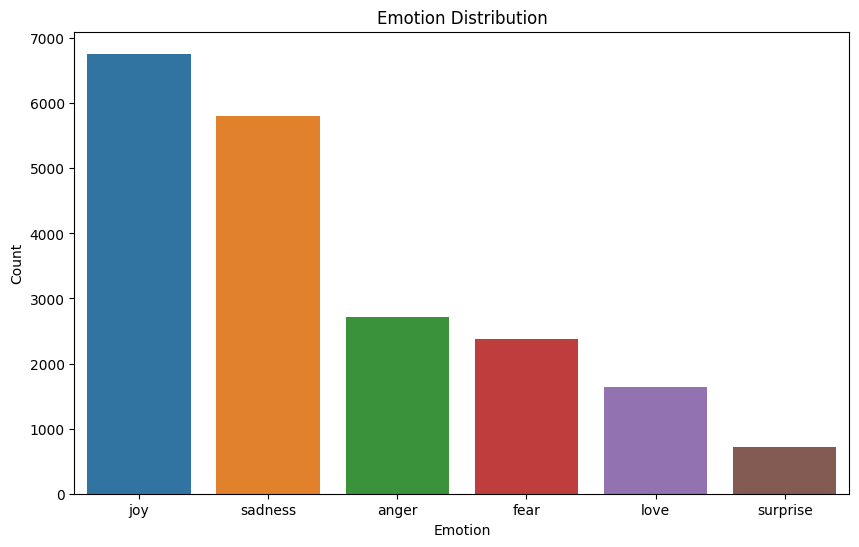

In [ ]:
# Emotion distribution
emotion_counts = combined_df['Emotion'].value_counts()
emotion_labels = list(label_encoder.inverse_transform(emotion_counts.index))
emotion_distribution = emotion_counts.values
# Plot the emotion distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=emotion_labels, y=emotion_distribution)
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

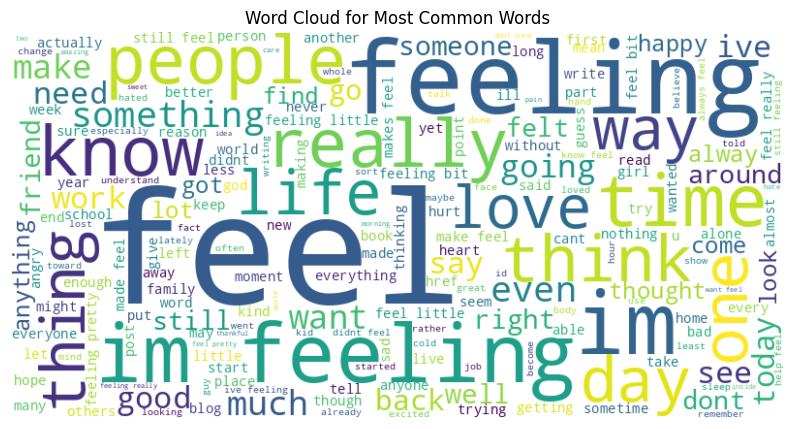

In [ ]:
# Word cloud for most common words
from wordcloud import WordCloud

# Combine text from all rows
all_text = ' '.join(combined_df['Text'])

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud for Most Common Words")
plt.axis('off')
plt.show()

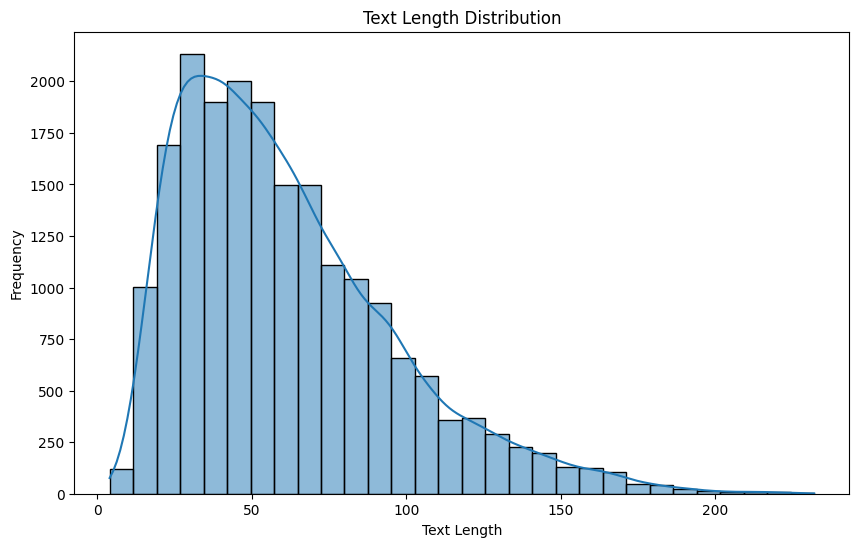

In [ ]:
# Explore text length distribution
text_lengths = combined_df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=30, kde=True)
plt.title("Text Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#Feature Engineering

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  #

# Fit and transform the TF-IDF vectorizer on the training data
tfidf_train = tfidf_vectorizer.fit_transform(train_data['Text'])

# Transform the test and validation data using the same vectorizer
tfidf_test = tfidf_vectorizer.transform(test_data['Text'])
tfidf_val = tfidf_vectorizer.transform(val_data['Text'])

# Convert the TF-IDF matrices to DataFrames for further processing
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_val_df = pd.DataFrame(tfidf_val.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the original DataFrames
train_data = pd.concat([train_data, tfidf_train_df], axis=1)
test_data = pd.concat([test_data, tfidf_test_df], axis=1)
val_data = pd.concat([val_data, tfidf_val_df], axis=1)

# Print a sample from the updated DataFrames to verify
print("Sample from Train Data with TF-IDF Features:")
print(train_data.head(1))


Sample from Train Data with TF-IDF Features:
                                                    Text  Emotion   aa  \
13205  id love see campaign go viral help raise aware...      2.0  0.0   

       abandon  abandoned  abc  abilities  ability  abit  able  ...  youthful  \
13205      0.0        0.0  0.0        0.0      0.0   0.0   0.0  ...       0.0   

       youtube  youve  yuuki  zach  zealand  zero  zombie  zone  zumba  
13205      0.0    0.0    0.0   0.0      0.0   0.0     0.0   0.0    0.0  

[1 rows x 5002 columns]


In [ ]:
#Model BUilding

In [ ]:
# # Split the dataset into train, test, and validation sets
train_data, test_data = train_test_split(combined_df, test_size=0.15, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the TF-IDF vectorizer on the training data
tfidf_train = tfidf_vectorizer.fit_transform(train_data['Text'])
tfidf_val = tfidf_vectorizer.transform(val_data['Text'])
tfidf_test = tfidf_vectorizer.transform(test_data['Text'])

In [ ]:
# Define and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(tfidf_train, train_data['Emotion'])

RandomForestClassifier(random_state=42)

In [ ]:
# Evaluate the Random Forest model on the validation set
val_predictions = rf_model.predict(tfidf_val)
print("Validation Set - Random Forest Model")
print(classification_report(val_data['Emotion'], val_predictions))

Validation Set - Random Forest Model
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       199
           1       0.78      0.89      0.83       166
           2       0.89      0.90      0.90       523
           3       0.77      0.78      0.77       117
           4       0.93      0.92      0.92       435
           5       0.91      0.70      0.79        60

    accuracy                           0.88      1500
   macro avg       0.86      0.84      0.85      1500
weighted avg       0.88      0.88      0.88      1500



In [ ]:
# Evaluate the Random Forest model on the test set
test_predictions = rf_model.predict(tfidf_test)
print("Test Set - Random Forest Model")
print(classification_report(test_data['Emotion'], test_predictions))

Test Set - Random Forest Model
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       207
           1       0.85      0.82      0.84       188
           2       0.88      0.93      0.90       471
           3       0.84      0.78      0.81       139
           4       0.92      0.89      0.91       438
           5       0.81      0.77      0.79        57

    accuracy                           0.88      1500
   macro avg       0.86      0.85      0.85      1500
weighted avg       0.88      0.88      0.88      1500

